Change Log:
- v30 - binary second run, without dt_diff, using correct parameters
- v23 - build two model for each price group, limit the training set to each target price group
- v20 - lower learning rate = 0.0008, add height_r and top_floor index
- v16 - change parameters (some from model 05), rm reduce to 68
- v14 - change random seed
- v10 - remove features based on feature importance results (exp-l04-per-area)

### Import packages

In [1]:
import time
import pickle
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from utilities import cal_mape

from utilities import cal_score, convert_types, create_dt_feats

In [2]:
model_name = 'model-30-lgb-binary-2'

### Params

In [3]:
is_log_target = True
is_per_area_target = True
is_duplicated_train = False

map_target = {
    (True, True):   'log_per_area_total_price',
    (True, False):  'log_total_price',
    (False, True):  'per_area_total_price',
    (False, False): 'total_price'
}
col_target = map_target[(is_log_target, is_per_area_target)]

#cols_feats_add = ['encoded_latlon', 'building_per_land_area'] # add feats into model
cols_num_add = ['building_per_land_area', 'height_r']
cols_cat_add = ['encoded_latlon']

#cols_feats_rm = [] # TODO: implement before using it
#['day_in_year_txn_dt', 'day_in_year_building_complete_dt', 'dt_diff_building_complete_dt_txn_dt'] # dt num feats
#['dow_txn_dt', 'dow_building_complete_dt', 'month_txn_dt', 'month_building_complete_dt',
# 'quarter_txn_dt', 'quarter_building_complete_dt', 'year_txn_dt', 'year_building_complete_dt'] # dt cat feats

### Processing

In [4]:
def pre_processing(df, cols_num, cols_cat): #, cols_feats
    # Convert types
    df[cols_num] = df[cols_num].astype('float32')
    
    # generate target
    if 'total_price' in df:
        df['total_price'] = df['total_price'].astype('float32')
        df['log_total_price'] = np.log1p(df['total_price'])
        df['per_area_total_price'] = df['total_price'] / df['building_area']
        df['log_per_area_total_price'] = np.log1p(df['per_area_total_price'])
        df['target'] = df[col_target]

    # generate lat/lon encoded
    kmeans = pickle.load(open('./object_kmeans_k6_combined.pkl', 'rb'))
    df['encoded_latlon'] = kmeans.predict(df[['lat','lon']])
    
    # generate dt feats
    df = create_dt_feats(df, 'txn_dt')
    df = create_dt_feats(df, 'building_complete_dt')
    df['dt_diff_building_complete_dt_txn_dt'] = df['txn_dt'] - df['building_complete_dt']
    
    # generate building to land ratio
    df['building_per_land_area'] = df['building_area'] / df['land_area']
 
    #cols_feats = cols_num + cols_cat + cols_feats_add
    
    # fix town and city
    df['town'] = df['city'].astype('str')+'-'+df['town'].astype('str')
    df['village'] = df['town'].astype('str')+'-'+df['village'].astype('str')
    
    # height ratio
    df['height_r'] = df['txn_floor'] / df['total_floor']
    df['top_floor'] = df['txn_floor'] == df['total_floor']
    
    return df  #, cols_feats

In [5]:
from feature_engineering import CategoricalColumnsEncoder
from feature_engineering import TargetMeanEncoding
from feature_engineering import MultiLabelEncoding

class FeatureEngineering():
    def __init__(self, cols_num, cols_cat, cols_feats, col_target, n_ran_encode=4):
        # cols
        self.cols_num = cols_num
        self.cols_cat = cols_cat
        self.cols_feats = cols_feats
        self.col_target = col_target
        
        # Numbers
        self.n_ran_encode = n_ran_encode
        
        # encoders
        #self.tar_encoder = TargetMeanEncoding(col_target = self.col_target)
        #self.ran_encoder = MultiLabelEncoding(self.n_ran_encode)
        self.cat_astyper = CategoricalColumnsEncoder(mode='pandas')
        
    def fit_transform(self, df):
        df = df.copy()
    
#        encoded1 = self.tar_encoder.fit_transform(df[self.cols_cat], df[self.col_target])
#        encoded2 = self.ran_encoder.fit_transform(df[self.cols_cat])
        self.cat_astyper.fit_transform(df, self.cols_cat)    
        return df
#        return pd.concat([df, encoded1, encoded2], axis=1)
    
    def transform(self, df):
        df = df.copy()
#        encoded1 = self.tar_encoder.transform(df[self.cols_cat])
#        encoded2 = self.ran_encoder.transform(df[self.cols_cat])     # TODO: add generated feats into cols_feats
        self.cat_astyper.transform(df)
        return df
#        return pd.concat([df, encoded1, encoded2], axis=1)

In [6]:
def post_processing(y_pred, df):
    """Args: 
          y_pred (1d np.array): raw prediction y
          df (pd.Dataframe): input feature df
       Return: np.array
    """
    y_pred_final = y_pred.copy()
    
    if is_log_target:
        y_pred_final = np.expm1(y_pred_final)
        y_pred_final = np.clip(y_pred_final, 0, None)

    if is_per_area_target:
        y_pred_final = y_pred_final * df['building_area'].values
        
    return y_pred_final

### Columns

In [7]:
cols_num = ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor',
            'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area',
            'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate',
            'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate',
            'divorce_rate', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_100', 'I_250',
            'I_500', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_10', 'II_50', 'II_100', 'II_250', 'II_500',
            'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500',
            'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_50', 'IV_100', 'IV_250', 'IV_500',
            'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_10', 'V_50', 'V_100', 'V_250', 'V_500', 'V_1000',
            'V_5000', 'V_10000', 'V_MIN', 'VI_50', 'VI_100', 'VI_250', 'VI_500', 'VI_1000', 'VI_5000', 'VI_10000',
            'VI_MIN', 'VII_10', 'VII_50', 'VII_100', 'VII_250', 'VII_500', 'VII_1000', 'VII_5000', 'VII_10000',
            'VII_MIN', 'VIII_10', 'VIII_50', 'VIII_100', 'VIII_250', 'VIII_500', 'VIII_1000', 'VIII_5000',
            'VIII_10000', 'VIII_MIN', 'IX_10', 'IX_50', 'IX_100', 'IX_250', 'IX_500', 'IX_1000', 'IX_5000',
            'IX_10000', 'IX_MIN', 'X_10', 'X_50', 'X_100', 'X_250', 'X_500', 'X_1000', 'X_5000', 'X_10000', 'X_MIN',
            'XI_10', 'XI_50', 'XI_100', 'XI_250', 'XI_500', 'XI_1000', 'XI_5000', 'XI_10000', 'XI_MIN', 'XII_10',
            'XII_50', 'XII_100', 'XII_250', 'XII_500', 'XII_1000', 'XII_5000', 'XII_10000', 'XII_MIN', 'XIII_10',
            'XIII_50', 'XIII_100', 'XIII_250', 'XIII_500', 'XIII_1000', 'XIII_5000', 'XIII_10000', 'XIII_MIN',
            'XIV_10', 'XIV_50', 'XIV_100', 'XIV_250', 'XIV_500', 'XIV_1000', 'XIV_5000', 'XIV_10000', 'XIV_MIN']
cols_cat = ['building_material', 'city', 'building_type', 'building_use', 'parking_way', 'town', 'village',
            'I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000',
            'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000',
            'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500',
            'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500',
            'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50',
            'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000',
            'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500',
            'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500',
            'XIV_index_1000']
cols_feats = cols_num + cols_cat

# informational cols
cols_dt = ['txn_dt', 'building_complete_dt']
cols_bin = ['I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000',
            'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000',
            'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500',
            'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500',
            'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50',
            'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000',
            'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500',
            'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500',
            'XIV_index_1000']

### Read data

In [8]:
train = pd.read_csv('dataset/train.csv', dtype=object)
test = pd.read_csv('dataset/test.csv', dtype=object)

id_cv = []
for i in range(5):
    id_one_fold = pd.read_csv(f'dataset/id_cv{i}.csv', dtype=object)['building_id']
    id_cv.append(id_one_fold)

# Add price group predictions
train_group = pd.read_csv('output/metamodel-03-lgb-binary-cv.csv')  # add price group
train = train.merge(train_group, how='left', on='building_id')
assert not train['price_group_pred'].isnull().any()
train.check()

test_group = pd.read_csv('output/metamodel-03-lgb-binary-test-one.csv')  # add price group using one
test = test.merge(test_group, how='left', on='building_id')
assert not test['price_group_pred'].isnull().any()
test.check()

price_groups = sorted(train['price_group_pred'].unique())
print('Price groups:', 'N =', len(price_groups), price_groups)
print('Binary classification accuracy (train):', 
      '%.5f'%(train['price_group'] == train['price_group_pred']).mean())

,building_id,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,...,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,total_price,price_group,price_group_pred
0,e3mMIMR3JJqCaXz1,8,21,18674,4,3,2,6271,2,NaN,...,157,1,2483,1,6011,1,34.469802848528126,647603.7704719775,0,0
1,LgwzgklNvy4QCtq5,8,7,18800,5,1,2,7885,2,NaN,...,115,1,15872,1,32221,1,40.07357348973039,3321452.0,1,1
2,ucIR2NLLsC3T650L,8,7,19289,4,1,2,6028,2,NaN,...,212,1,15760,1,32228,1,54.46208108983661,9570885.316206373,1,1
3,jre1pJhcQj91Kdky,8,21,20385,24,0,2,18325,0,NaN,...,125,1,2568,1,7271,1,99.62896580763416,14215011.127100045,1,1
4,rQpYpY9nRG7X5mmr,1,21,20657,2,4,2,6880,2,NaN,...,47,1,2587,1,7442,1,124.1312362968124,762711.9757135696,0,0
59995,Oh5Hwr9LrWApC2mr,1,5,19040,2,4,2,9193,2,NaN,...,53,1,1435,1,4611,1,145.27967019169262,987021.4150420949,0,0
59996,PiOgZqfsDVlTq1zs,8,13,19706,14,2,5,17168,0,3.738411744735565,...,316,1,5659,1,22826,1,18.81499793345573,15725223.997450478,1,1
59997,FQmlgGohzzWuKUzu,8,7,19901,11,0,2,13729,0,NaN,...,348,1,13252,1,32687,1,94.79959334423607,11815402.03862225,1,1
59998,zjzfMwXhDswdEaI2,8,13,19975,5,1,2,7063,2,NaN,...,142,1,5317,1,21087,1,33.10458025153816,18084995.81999832,1,1
59999,iN4H6wBMtvJpF0SN,8,7,20385,5,1,2,8310,2,NaN,...,249,1,15417,1,32826,1,47.50987600102272,8510295.87633061,1,1


shape = (60000, 237)


,building_id,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,...,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,price_group_pred
0,X5gsdTWGS3W7JJQB,1,13,18634,2,4,2,1857,2,NaN,...,21,1,129,1,3991,1,8409,1,105.4622312795739,1
1,BTshNOJyKHnT2YIT,8,7,20199,10,3,2,16011,2,NaN,...,44,1,67,1,1950,1,10725,1,100.81980868401074,0
2,dhdymr0lV8N5kZOT,8,12,19769,4,4,10,18294,2,NaN,...,3,1,35,1,3707,1,19459,1,259.8005430183116,1
3,VEwyGGMcD56w5BOc,10,7,20479,19,2,0,17837,2,NaN,...,60,1,144,1,6487,1,29400,1,22.941906168328487,1
4,wmUeMoJZfsqaSX9b,8,3,18164,13,0,2,13272,2,NaN,...,18,1,76,1,1346,1,3280,1,181.21309507601745,0
9995,UEeCDaAJzPwdKKKA,8,3,19494,6,3,2,12115,2,NaN,...,5,1,35,1,1118,1,3408,1,276.63801953982124,0
9996,i0fgbPaQsDWs7Q87,8,13,19166,13,0,2,17502,0,8.654350043224781,...,23,1,66,1,3773,1,16164,1,46.55561753672866,1
9997,YunNwAhcqkf6YclI,8,5,19340,3,4,2,11324,2,NaN,...,7,1,42,1,1354,1,5693,1,13.622703036125506,0
9998,A2NotxtRY9MYoWMl,8,7,18184,5,1,2,7885,2,NaN,...,182,1,840,1,6469,1,31383,1,91.48925980597359,1
9999,kKvgBXiA50gRmQhP,8,21,20370,6,3,2,11142,2,NaN,...,26,1,119,1,3769,1,9529,1,124.55299965753014,0


shape = (10000, 235)
Price groups: N = 2 [0, 1]
Binary classification accuracy (train): 0.95893


### Preprocessing

In [9]:
train = pre_processing(train, cols_num, cols_cat)
test = pre_processing(test, cols_num, cols_cat)

c:\python36\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator KMeans from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
c:\python36\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator KMeans from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [10]:
cols_num = cols_num + [c for c in cols_num_add if c not in cols_num]
cols_cat = cols_cat + [c for c in cols_cat_add if c not in cols_cat]
cols_feats = cols_num + cols_cat

### Remove feats based on shuffle results

In [11]:
# PARS #
N_feats_rm = 68
# PARS #

from vars_03 import score_base_per_area, shuffle_results_per_area

feat_imp = pd.DataFrame({'feats': shuffle_results_per_area[:,0],
                         'avg':shuffle_results_per_area[:,1]})
feat_imp['diff'] = feat_imp['avg'] - score_base_per_area
feat_imp = feat_imp.sort_values(by='diff', ascending=False)
print(feat_imp.reset_index().values)

feats_rm = list(feat_imp.iloc[:(N_feats_rm+1)]['feats'].values)
#feats_rm.remove('none')
print(len(feats_rm))
print(feats_rm)

print('N feats (before):', len(cols_feats))
cols_feats = list(set(cols_feats) - set(feats_rm))
print('N feats (after):', len(cols_feats))
print(cols_feats)

[[0 'divorce_rate' 5709.20035 3.333296666667593]
 [1 'I_250' 5709.200316666666 3.333263333333889]
 [2 'XI_100' 5708.200346666667 2.33329333333495]
 [3 'VI_index_500' 5707.867050000001 1.9999966666682667]
 [4 'IX_index_50' 5707.86704 1.9999866666676098]
 [5 'VI_500' 5707.866983333333 1.9999300000008589]
 [6 'XIV_10' 5707.533710000001 1.666656666668132]
 [7 'XI_index_500' 5707.200386666666 1.3333333333339397]
 [8 'VI_index_1000' 5707.200383333334 1.3333300000012969]
 [9 'V_100' 5707.200373333333 1.33332000000064]
 [10 'VII_10' 5707.200363333334 1.333310000001802]
 [11 'X_100' 5707.200336666666 1.3332833333333838]
 [12 'XII_index_50' 5706.867056666667 1.0000033333344618]
 [15 'X_index_500' 5706.867050000001 0.9999966666682667]
 [14 'X_10' 5706.867050000001 0.9999966666682667]
 [13 'II_10' 5706.867050000001 0.9999966666682667]
 [16 'II_index_500' 5706.867046666666 0.9999933333338049]
 [17 'V_index_1000' 5706.867046666666 0.9999933333338049]
 [18 'XIII_10' 5706.867043333335 0.99999000000207

### Params

In [12]:
# params
# parameters from model 10: 24, 300, 0.5, 10, 0.1, 0.0
# parameters from model 5: 24, 258, 0.4, 6, 0.04, 0.02
params = {'task': 'train',
          'boosting_type': 'gbdt',
          'objective': 'mse',
          'metric': 'mape',
          'learning_rate': 0.0005, # 0.001
          'max_depth': 24,
          'num_leaves': 127,           # may reduce in dim-reduction exp
          'feature_fraction': 0.4,
          'min_data_in_leaf': 6,
          'lambda_l1': 0.01,
          'lambda_l2': 0.01,
          'max_bin': 255,
          'min_sum_hessian_in_leaf': 0.001,
          'min_data_per_group': 10,
          'seed': 4433,
         }

lgb_other_params = {'num_boost_round': 1000000,  # expected to stop 250000
                    'verbose_eval': 2000,
                    'early_stopping_rounds': 1000,
                    'keep_training_booster': True,
                   }


### kfold cross-predict

In [13]:
t0 = time.time()

predicts_val = []
predicts_test = test[['building_id']].copy()
best_iterations = []
scores = []; mapes = []
for i, id_fold in enumerate(id_cv):
    #id_fold = id_fold['building_id']
    # split train, val
    df_train = train.loc[~train['building_id'].isin(id_fold)].copy()
    df_val = train.loc[train['building_id'].isin(id_fold)].copy()
    df_test = test.copy()
    
    # feat eng
    feat_eng = FeatureEngineering(cols_num, cols_cat, cols_feats, col_target)
    df_train = feat_eng.fit_transform(df_train)
    df_val = feat_eng.transform(df_val)
    df_test = feat_eng.transform(df_test)
    
    # split price group
    best_iters = []
    for pg in price_groups:
        df_train_g = df_train.loc[df_train['price_group_pred'] == pg]
        df_val_g = df_val.loc[df_val['price_group_pred'] == pg]

        if is_duplicated_train:
            df_train_g = pd.concat([df_train_g, df_train], ignore_index=True)
        
        # Construct lgb dataset
        lgb_train = lgb.Dataset(df_train_g[cols_feats], df_train_g[col_target]).construct()
        lgb_val = lgb.Dataset(df_val_g[cols_feats], df_val_g[col_target], reference=lgb_train).construct()
        
        # train model    
        model = lgb.train(params, lgb_train, valid_sets=lgb_val, **lgb_other_params)
        best_iters.append(model.best_iteration)

        # Predict on val set
        val_pg_mask = df_val['price_group_pred'] == pg
        df_val.loc[val_pg_mask, col_target+'_pred'] = (
            model.predict(df_val.loc[val_pg_mask, cols_feats])
        )
        
        # Predict on test set
        test_pg_mask = df_test['price_group_pred'] == pg
        predicts_test.loc[test_pg_mask, 'target_{}'.format(i)] = (
            model.predict(df_test.loc[test_pg_mask, cols_feats])
        )
    
    mse = mean_squared_error(df_val[col_target], df_val[col_target+'_pred'])
    mae = mean_absolute_error(df_val[col_target], df_val[col_target+'_pred'])
    mape = cal_mape(df_val[col_target], df_val[col_target+'_pred'])
    mapes.append(mape)
    
    y_pred_final = post_processing(df_val[col_target+'_pred'], df_val)
    score = cal_score(df_val['total_price'], y_pred_final)
    scores.append(score)
    best_iterations.append(best_iters)

    print('(Fold %d) score, mse, mae, mape: %.5f, %.5f, %.5f, %.5f.' % (i, score, mse, mae, mape))
    predicts_val.append(pd.DataFrame({'building_id': df_val['building_id'],
                                      'total_price': df_val['total_price'],
                                      'total_price_predict': y_pred_final}))

Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0214291
[4000]	valid_0's mape: 0.0168117
[6000]	valid_0's mape: 0.0148837
[8000]	valid_0's mape: 0.0139129
[10000]	valid_0's mape: 0.0133486
[12000]	valid_0's mape: 0.0129714
[14000]	valid_0's mape: 0.0126973
[16000]	valid_0's mape: 0.012491
[18000]	valid_0's mape: 0.0123265
[20000]	valid_0's mape: 0.012192
[22000]	valid_0's mape: 0.01208
[24000]	valid_0's mape: 0.0119864
[26000]	valid_0's mape: 0.0119062
[28000]	valid_0's mape: 0.0118373
[30000]	valid_0's mape: 0.0117767
[32000]	valid_0's mape: 0.0117244
[34000]	valid_0's mape: 0.0116777
[36000]	valid_0's mape: 0.011637
[38000]	valid_0's mape: 0.0116006
[40000]	valid_0's mape: 0.0115675
[42000]	valid_0's mape: 0.0115382
[44000]	valid_0's mape: 0.011513
[46000]	valid_0's mape: 0.0114888
[48000]	valid_0's mape: 0.011467
[50000]	valid_0's mape: 0.0114461
[52000]	valid_0's mape: 0.0114271
[54000]	valid_0's mape: 0.0114101
[56000]	valid_0's mape: 0.011

[472000]	valid_0's mape: 0.0110739
[474000]	valid_0's mape: 0.0110738
[476000]	valid_0's mape: 0.0110738
[478000]	valid_0's mape: 0.0110738
[480000]	valid_0's mape: 0.0110737
[482000]	valid_0's mape: 0.0110737
[484000]	valid_0's mape: 0.0110736
[486000]	valid_0's mape: 0.0110736
[488000]	valid_0's mape: 0.0110735
[490000]	valid_0's mape: 0.0110735
[492000]	valid_0's mape: 0.0110735
[494000]	valid_0's mape: 0.0110734
[496000]	valid_0's mape: 0.0110734
[498000]	valid_0's mape: 0.0110734
[500000]	valid_0's mape: 0.0110733
[502000]	valid_0's mape: 0.0110733
[504000]	valid_0's mape: 0.0110733
[506000]	valid_0's mape: 0.0110732
[508000]	valid_0's mape: 0.0110732
[510000]	valid_0's mape: 0.0110731
[512000]	valid_0's mape: 0.0110731
[514000]	valid_0's mape: 0.0110731
[516000]	valid_0's mape: 0.0110731
[518000]	valid_0's mape: 0.011073
[520000]	valid_0's mape: 0.011073
[522000]	valid_0's mape: 0.011073
[524000]	valid_0's mape: 0.0110729
[526000]	valid_0's mape: 0.0110729
[528000]	valid_0's mape

[304000]	valid_0's mape: 0.00726425
[306000]	valid_0's mape: 0.00726398
[308000]	valid_0's mape: 0.00726374
[310000]	valid_0's mape: 0.0072635
[312000]	valid_0's mape: 0.00726328
[314000]	valid_0's mape: 0.00726308
[316000]	valid_0's mape: 0.00726291
[318000]	valid_0's mape: 0.00726274
[320000]	valid_0's mape: 0.00726257
[322000]	valid_0's mape: 0.00726238
[324000]	valid_0's mape: 0.00726223
[326000]	valid_0's mape: 0.00726205
[328000]	valid_0's mape: 0.00726188
[330000]	valid_0's mape: 0.00726169
[332000]	valid_0's mape: 0.00726153
[334000]	valid_0's mape: 0.00726134
[336000]	valid_0's mape: 0.00726115
[338000]	valid_0's mape: 0.00726094
[340000]	valid_0's mape: 0.00726071
[342000]	valid_0's mape: 0.00726052
[344000]	valid_0's mape: 0.00726034
[346000]	valid_0's mape: 0.00726017
[348000]	valid_0's mape: 0.00726002
[350000]	valid_0's mape: 0.0072599
[352000]	valid_0's mape: 0.00725977
[354000]	valid_0's mape: 0.00725965
[356000]	valid_0's mape: 0.00725949
[358000]	valid_0's mape: 0.007

[110000]	valid_0's mape: 0.0115118
[112000]	valid_0's mape: 0.0115076
[114000]	valid_0's mape: 0.0115037
[116000]	valid_0's mape: 0.0115006
[118000]	valid_0's mape: 0.0114972
[120000]	valid_0's mape: 0.0114939
[122000]	valid_0's mape: 0.0114906
[124000]	valid_0's mape: 0.0114878
[126000]	valid_0's mape: 0.0114849
[128000]	valid_0's mape: 0.0114817
[130000]	valid_0's mape: 0.011479
[132000]	valid_0's mape: 0.0114761
[134000]	valid_0's mape: 0.0114731
[136000]	valid_0's mape: 0.0114703
[138000]	valid_0's mape: 0.0114682
[140000]	valid_0's mape: 0.0114661
[142000]	valid_0's mape: 0.0114637
[144000]	valid_0's mape: 0.0114613
[146000]	valid_0's mape: 0.0114591
[148000]	valid_0's mape: 0.0114568
[150000]	valid_0's mape: 0.0114548
[152000]	valid_0's mape: 0.011453
[154000]	valid_0's mape: 0.0114513
[156000]	valid_0's mape: 0.0114497
[158000]	valid_0's mape: 0.0114482
[160000]	valid_0's mape: 0.0114466
[162000]	valid_0's mape: 0.0114451
[164000]	valid_0's mape: 0.0114439
[166000]	valid_0's map

[580000]	valid_0's mape: 0.0113852
[582000]	valid_0's mape: 0.0113852
[584000]	valid_0's mape: 0.0113852
[586000]	valid_0's mape: 0.0113852
[588000]	valid_0's mape: 0.0113851
[590000]	valid_0's mape: 0.0113851
[592000]	valid_0's mape: 0.0113851
[594000]	valid_0's mape: 0.0113851
[596000]	valid_0's mape: 0.011385
[598000]	valid_0's mape: 0.011385
[600000]	valid_0's mape: 0.011385
[602000]	valid_0's mape: 0.011385
[604000]	valid_0's mape: 0.011385
[606000]	valid_0's mape: 0.011385
[608000]	valid_0's mape: 0.0113849
[610000]	valid_0's mape: 0.0113849
[612000]	valid_0's mape: 0.0113849
[614000]	valid_0's mape: 0.0113849
[616000]	valid_0's mape: 0.0113849
[618000]	valid_0's mape: 0.0113849
[620000]	valid_0's mape: 0.0113848
[622000]	valid_0's mape: 0.0113848
[624000]	valid_0's mape: 0.0113848
[626000]	valid_0's mape: 0.0113848
[628000]	valid_0's mape: 0.0113848
[630000]	valid_0's mape: 0.0113848
Early stopping, best iteration is:
[629220]	valid_0's mape: 0.0113848
Training until validation 

[406000]	valid_0's mape: 0.00736563
[408000]	valid_0's mape: 0.00736556
[410000]	valid_0's mape: 0.00736549
[412000]	valid_0's mape: 0.00736545
[414000]	valid_0's mape: 0.00736541
[416000]	valid_0's mape: 0.00736537
[418000]	valid_0's mape: 0.00736533
[420000]	valid_0's mape: 0.00736529
[422000]	valid_0's mape: 0.00736526
[424000]	valid_0's mape: 0.00736523
[426000]	valid_0's mape: 0.00736519
[428000]	valid_0's mape: 0.00736514
[430000]	valid_0's mape: 0.00736509
[432000]	valid_0's mape: 0.00736504
[434000]	valid_0's mape: 0.00736499
[436000]	valid_0's mape: 0.00736495
[438000]	valid_0's mape: 0.0073649
[440000]	valid_0's mape: 0.00736486
[442000]	valid_0's mape: 0.00736482
[444000]	valid_0's mape: 0.00736479
[446000]	valid_0's mape: 0.00736475
[448000]	valid_0's mape: 0.0073647
[450000]	valid_0's mape: 0.00736466
[452000]	valid_0's mape: 0.00736462
[454000]	valid_0's mape: 0.00736458
[456000]	valid_0's mape: 0.00736454
[458000]	valid_0's mape: 0.00736449
[460000]	valid_0's mape: 0.007

[334000]	valid_0's mape: 0.0113274
[336000]	valid_0's mape: 0.0113272
[338000]	valid_0's mape: 0.0113271
[340000]	valid_0's mape: 0.0113269
[342000]	valid_0's mape: 0.0113267
[344000]	valid_0's mape: 0.0113266
[346000]	valid_0's mape: 0.0113264
[348000]	valid_0's mape: 0.0113261
[350000]	valid_0's mape: 0.0113259
[352000]	valid_0's mape: 0.0113258
[354000]	valid_0's mape: 0.0113256
[356000]	valid_0's mape: 0.0113255
[358000]	valid_0's mape: 0.0113253
[360000]	valid_0's mape: 0.0113252
[362000]	valid_0's mape: 0.011325
[364000]	valid_0's mape: 0.0113249
[366000]	valid_0's mape: 0.0113248
[368000]	valid_0's mape: 0.0113247
[370000]	valid_0's mape: 0.0113245
[372000]	valid_0's mape: 0.0113244
[374000]	valid_0's mape: 0.0113242
[376000]	valid_0's mape: 0.0113241
[378000]	valid_0's mape: 0.011324
[380000]	valid_0's mape: 0.0113239
[382000]	valid_0's mape: 0.0113239
[384000]	valid_0's mape: 0.0113238
[386000]	valid_0's mape: 0.0113237
[388000]	valid_0's mape: 0.0113236
[390000]	valid_0's map

[148000]	valid_0's mape: 0.00740871
[150000]	valid_0's mape: 0.00740754
[152000]	valid_0's mape: 0.00740613
[154000]	valid_0's mape: 0.00740456
[156000]	valid_0's mape: 0.00740316
[158000]	valid_0's mape: 0.00740166
[160000]	valid_0's mape: 0.00740032
[162000]	valid_0's mape: 0.00739906
[164000]	valid_0's mape: 0.00739795
[166000]	valid_0's mape: 0.00739686
[168000]	valid_0's mape: 0.00739582
[170000]	valid_0's mape: 0.00739474
[172000]	valid_0's mape: 0.00739354
[174000]	valid_0's mape: 0.00739233
[176000]	valid_0's mape: 0.00739113
[178000]	valid_0's mape: 0.00738998
[180000]	valid_0's mape: 0.00738884
[182000]	valid_0's mape: 0.00738784
[184000]	valid_0's mape: 0.00738701
[186000]	valid_0's mape: 0.0073862
[188000]	valid_0's mape: 0.00738538
[190000]	valid_0's mape: 0.00738437
[192000]	valid_0's mape: 0.00738342
[194000]	valid_0's mape: 0.0073829
[196000]	valid_0's mape: 0.00738252
[198000]	valid_0's mape: 0.00738193
[200000]	valid_0's mape: 0.00738138
[202000]	valid_0's mape: 0.007

[606000]	valid_0's mape: 0.00735148
[608000]	valid_0's mape: 0.00735146
[610000]	valid_0's mape: 0.00735143
[612000]	valid_0's mape: 0.00735142
[614000]	valid_0's mape: 0.0073514
[616000]	valid_0's mape: 0.00735139
[618000]	valid_0's mape: 0.00735137
[620000]	valid_0's mape: 0.00735136
[622000]	valid_0's mape: 0.00735134
[624000]	valid_0's mape: 0.00735133
[626000]	valid_0's mape: 0.00735131
[628000]	valid_0's mape: 0.0073513
[630000]	valid_0's mape: 0.00735128
[632000]	valid_0's mape: 0.00735126
[634000]	valid_0's mape: 0.00735124
[636000]	valid_0's mape: 0.00735123
[638000]	valid_0's mape: 0.00735121
[640000]	valid_0's mape: 0.0073512
[642000]	valid_0's mape: 0.00735118
[644000]	valid_0's mape: 0.00735117
[646000]	valid_0's mape: 0.00735116
[648000]	valid_0's mape: 0.00735114
[650000]	valid_0's mape: 0.00735113
[652000]	valid_0's mape: 0.00735112
[654000]	valid_0's mape: 0.00735112
[656000]	valid_0's mape: 0.00735111
[658000]	valid_0's mape: 0.00735109
[660000]	valid_0's mape: 0.0073

[388000]	valid_0's mape: 0.0113793
[390000]	valid_0's mape: 0.0113792
[392000]	valid_0's mape: 0.0113791
[394000]	valid_0's mape: 0.011379
[396000]	valid_0's mape: 0.0113789
[398000]	valid_0's mape: 0.0113788
[400000]	valid_0's mape: 0.0113788
[402000]	valid_0's mape: 0.0113787
[404000]	valid_0's mape: 0.0113786
[406000]	valid_0's mape: 0.0113785
[408000]	valid_0's mape: 0.0113784
[410000]	valid_0's mape: 0.0113783
[412000]	valid_0's mape: 0.0113782
[414000]	valid_0's mape: 0.0113781
[416000]	valid_0's mape: 0.011378
[418000]	valid_0's mape: 0.011378
[420000]	valid_0's mape: 0.0113779
[422000]	valid_0's mape: 0.0113778
[424000]	valid_0's mape: 0.0113777
[426000]	valid_0's mape: 0.0113776
[428000]	valid_0's mape: 0.0113775
[430000]	valid_0's mape: 0.0113774
[432000]	valid_0's mape: 0.0113773
[434000]	valid_0's mape: 0.0113772
[436000]	valid_0's mape: 0.0113771
[438000]	valid_0's mape: 0.0113771
[440000]	valid_0's mape: 0.011377
[442000]	valid_0's mape: 0.0113769
[444000]	valid_0's mape:

[196000]	valid_0's mape: 0.00745323
[198000]	valid_0's mape: 0.00745248
[200000]	valid_0's mape: 0.00745175
[202000]	valid_0's mape: 0.00745118
[204000]	valid_0's mape: 0.00745061
[206000]	valid_0's mape: 0.00745012
[208000]	valid_0's mape: 0.00744955
[210000]	valid_0's mape: 0.00744889
[212000]	valid_0's mape: 0.00744824
[214000]	valid_0's mape: 0.00744761
[216000]	valid_0's mape: 0.00744693
[218000]	valid_0's mape: 0.00744646
[220000]	valid_0's mape: 0.00744592
[222000]	valid_0's mape: 0.00744541
[224000]	valid_0's mape: 0.00744493
[226000]	valid_0's mape: 0.00744442
[228000]	valid_0's mape: 0.00744405
[230000]	valid_0's mape: 0.00744363
[232000]	valid_0's mape: 0.00744312
[234000]	valid_0's mape: 0.00744263
[236000]	valid_0's mape: 0.0074422
[238000]	valid_0's mape: 0.00744182
[240000]	valid_0's mape: 0.00744145
[242000]	valid_0's mape: 0.00744106
[244000]	valid_0's mape: 0.00744075
[246000]	valid_0's mape: 0.00744049
[248000]	valid_0's mape: 0.00744018
[250000]	valid_0's mape: 0.00

[154000]	valid_0's mape: 0.0111351
[156000]	valid_0's mape: 0.0111332
[158000]	valid_0's mape: 0.0111314
[160000]	valid_0's mape: 0.0111297
[162000]	valid_0's mape: 0.0111281
[164000]	valid_0's mape: 0.0111263
[166000]	valid_0's mape: 0.0111247
[168000]	valid_0's mape: 0.011123
[170000]	valid_0's mape: 0.0111215
[172000]	valid_0's mape: 0.01112
[174000]	valid_0's mape: 0.0111188
[176000]	valid_0's mape: 0.0111176
[178000]	valid_0's mape: 0.0111163
[180000]	valid_0's mape: 0.0111151
[182000]	valid_0's mape: 0.0111139
[184000]	valid_0's mape: 0.0111127
[186000]	valid_0's mape: 0.0111116
[188000]	valid_0's mape: 0.0111104
[190000]	valid_0's mape: 0.0111092
[192000]	valid_0's mape: 0.0111078
[194000]	valid_0's mape: 0.0111066
[196000]	valid_0's mape: 0.0111054
[198000]	valid_0's mape: 0.0111043
[200000]	valid_0's mape: 0.0111032
[202000]	valid_0's mape: 0.0111019
[204000]	valid_0's mape: 0.0111005
[206000]	valid_0's mape: 0.0110994
[208000]	valid_0's mape: 0.0110984
[210000]	valid_0's mape

[624000]	valid_0's mape: 0.0110604
[626000]	valid_0's mape: 0.0110604
[628000]	valid_0's mape: 0.0110604
Early stopping, best iteration is:
[628741]	valid_0's mape: 0.0110604
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0169783
[4000]	valid_0's mape: 0.0120126
[6000]	valid_0's mape: 0.0103108
[8000]	valid_0's mape: 0.00955873
[10000]	valid_0's mape: 0.00914228
[12000]	valid_0's mape: 0.00886963
[14000]	valid_0's mape: 0.00867711
[16000]	valid_0's mape: 0.00853177
[18000]	valid_0's mape: 0.00841562
[20000]	valid_0's mape: 0.00832129
[22000]	valid_0's mape: 0.00824343
[24000]	valid_0's mape: 0.00817603
[26000]	valid_0's mape: 0.00811832
[28000]	valid_0's mape: 0.00806882
[30000]	valid_0's mape: 0.0080254
[32000]	valid_0's mape: 0.0079873
[34000]	valid_0's mape: 0.0079531
[36000]	valid_0's mape: 0.00792261
[38000]	valid_0's mape: 0.00789631
[40000]	valid_0's mape: 0.00787207
[42000]	valid_0's mape: 0.00785049
[44000]	valid_0's mape: 0.00783028
[

[448000]	valid_0's mape: 0.00747707
[450000]	valid_0's mape: 0.007477
[452000]	valid_0's mape: 0.00747695
[454000]	valid_0's mape: 0.00747689
[456000]	valid_0's mape: 0.00747684
[458000]	valid_0's mape: 0.00747679
[460000]	valid_0's mape: 0.00747673
[462000]	valid_0's mape: 0.00747668
[464000]	valid_0's mape: 0.00747662
[466000]	valid_0's mape: 0.00747656
[468000]	valid_0's mape: 0.00747652
[470000]	valid_0's mape: 0.00747647
[472000]	valid_0's mape: 0.00747642
[474000]	valid_0's mape: 0.00747638
[476000]	valid_0's mape: 0.00747633
[478000]	valid_0's mape: 0.00747629
[480000]	valid_0's mape: 0.00747624
[482000]	valid_0's mape: 0.0074762
[484000]	valid_0's mape: 0.00747615
[486000]	valid_0's mape: 0.00747611
[488000]	valid_0's mape: 0.00747606
[490000]	valid_0's mape: 0.00747601
[492000]	valid_0's mape: 0.00747597
[494000]	valid_0's mape: 0.00747592
[496000]	valid_0's mape: 0.00747588
[498000]	valid_0's mape: 0.00747584
[500000]	valid_0's mape: 0.0074758
[502000]	valid_0's mape: 0.00747

In [14]:
print('Total run time:', time.time() - t0)

Total run time: 94034.13044452667


In [15]:
print('Kfold cv score (mean, stdev, all):', np.mean(scores), np.std(scores), scores) # 5868.87314
print('Kfold cv mape (mean, stdev, all):', np.mean(mapes), np.std(mapes), mapes)

Kfold cv score (mean, stdev, all): 5864.472101024742 26.00353657974239 [5836.875245011362, 5877.871987886528, 5908.870406620498, 5851.872056950465, 5846.870808654856]
Kfold cv mape (mean, stdev, all): 0.009239611304387484 7.311196062987367e-05 [0.009115491786413651, 0.009284880023202076, 0.009277544792294501, 0.009319213089816229, 0.009200926830210962]


In [16]:
predicts_test.head()

,building_id,target_0,target_1,target_2,target_3,target_4
0,X5gsdTWGS3W7JJQB,15.117310,15.141656,15.224172,15.216356,15.103471
1,BTshNOJyKHnT2YIT,13.142090,13.131333,13.145620,13.139349,13.139764
2,dhdymr0lV8N5kZOT,13.861445,13.781816,13.832342,13.792210,13.814192
3,VEwyGGMcD56w5BOc,14.804456,14.786530,14.771827,14.792138,14.775308
4,wmUeMoJZfsqaSX9b,12.161154,12.145708,12.108649,12.212375,12.200663


In [17]:
pd.concat(predicts_val, axis=0).to_csv('output/'+model_name+'-cv.csv', index=False)

predicts_test['target_mean'] = \
    predicts_test[['target_'+str(i) for i in range(len(id_cv))]].mean(axis=1)
predicts_test['total_price'] = post_processing(predicts_test['target_mean'].values, df_test)
predicts_test[['building_id', 'total_price']].to_csv('output/'+model_name+'-test-kfold.csv', index=False)

In [18]:
print('Best iterations:', best_iterations)
pg_mean_best_iterations = {}
for i, pg in enumerate(price_groups):
    pg_mean_best_iterations[pg] = np.mean([x[i] for x in best_iterations])
    print('Group ', pg, 'mean best iterations:', int(pg_mean_best_iterations[pg]))

Best iterations: [[626858, 646956], [629220, 529046], [647095, 677846], [651942, 496122], [628741, 686183]]
Group  0 mean best iterations: 636771
Group  1 mean best iterations: 607230


### One-fold test

In [19]:
lgb_other_params_ones = {}
for pg in price_groups:
    lgb_other_params_one = {'num_boost_round': int(pg_mean_best_iterations[pg]*1.2),
                            'verbose_eval': 2000,
                            'keep_training_booster': True,
                           }
    lgb_other_params_ones[pg] = lgb_other_params_one
lgb_other_params_ones

{0: {'keep_training_booster': True,
  'num_boost_round': 764125,
  'verbose_eval': 2000},
 1: {'keep_training_booster': True,
  'num_boost_round': 728676,
  'verbose_eval': 2000}}

In [20]:
params

{'boosting_type': 'gbdt',
 'feature_fraction': 0.4,
 'lambda_l1': 0.01,
 'lambda_l2': 0.01,
 'learning_rate': 0.0005,
 'max_bin': 255,
 'max_depth': 24,
 'metric': 'mape',
 'min_data_in_leaf': 6,
 'min_data_per_group': 10,
 'min_sum_hessian_in_leaf': 0.001,
 'num_leaves': 127,
 'objective': 'mse',
 'seed': 4433,
 'task': 'train'}

In [21]:
t10 = time.time()

df_train = train.copy()
df_test = test.copy()

# feat eng
feat_eng = FeatureEngineering(cols_num, cols_cat, cols_feats, col_target)
df_train = feat_eng.fit_transform(df_train)
df_test = feat_eng.transform(df_test)

for pg in price_groups:
    df_train_g = df_train.loc[df_train['price_group_pred'] == pg]
    if is_duplicated_train:
        df_train_g = pd.concat([df_train_g, df_train], ignore_index=True)

    # Construct lgb dataset
    lgb_train = lgb.Dataset(df_train_g[cols_feats], df_train_g[col_target]).construct()

    # train model    
    model = lgb.train(params, lgb_train, valid_sets=lgb_train, **lgb_other_params_ones[pg])
    
    test_pg_mask = df_test['price_group_pred'] == pg
    df_test.loc[test_pg_mask, 'target_pred'] = (
        model.predict(df_test.loc[test_pg_mask, cols_feats])
    )

y_pred_final = post_processing(df_test['target_pred'], df_test)

df_test_pred = pd.DataFrame({'building_id': df_test['building_id'], 
                             'total_price': y_pred_final})

t11 = time.time()

display(df_test_pred.head(20))

[2000]	training's mape: 0.0205324
[4000]	training's mape: 0.0153421
[6000]	training's mape: 0.0128698
[8000]	training's mape: 0.0114424
[10000]	training's mape: 0.0104695
[12000]	training's mape: 0.00973661
[14000]	training's mape: 0.00914348
[16000]	training's mape: 0.00864391
[18000]	training's mape: 0.0082116
[20000]	training's mape: 0.00782766
[22000]	training's mape: 0.007484
[24000]	training's mape: 0.00717148
[26000]	training's mape: 0.00688851
[28000]	training's mape: 0.00662988
[30000]	training's mape: 0.00639164
[32000]	training's mape: 0.00617208
[34000]	training's mape: 0.0059682
[36000]	training's mape: 0.00577852
[38000]	training's mape: 0.00560123
[40000]	training's mape: 0.00543407
[42000]	training's mape: 0.00527572
[44000]	training's mape: 0.00512612
[46000]	training's mape: 0.0049831
[48000]	training's mape: 0.00484673
[50000]	training's mape: 0.00471514
[52000]	training's mape: 0.00459034
[54000]	training's mape: 0.00446986
[56000]	training's mape: 0.00435332
[58000

[444000]	training's mape: 0.00021107
[446000]	training's mape: 0.000208829
[448000]	training's mape: 0.000206565
[450000]	training's mape: 0.000204364
[452000]	training's mape: 0.00020213
[454000]	training's mape: 0.000199968
[456000]	training's mape: 0.00019785
[458000]	training's mape: 0.000195812
[460000]	training's mape: 0.000193769
[462000]	training's mape: 0.000191758
[464000]	training's mape: 0.000189787
[466000]	training's mape: 0.000187857
[468000]	training's mape: 0.000186022
[470000]	training's mape: 0.000184213
[472000]	training's mape: 0.000182468
[474000]	training's mape: 0.000180759
[476000]	training's mape: 0.000179069
[478000]	training's mape: 0.000177303
[480000]	training's mape: 0.000175541
[482000]	training's mape: 0.000173812
[484000]	training's mape: 0.000172093
[486000]	training's mape: 0.000170382
[488000]	training's mape: 0.000168679
[490000]	training's mape: 0.000167058
[492000]	training's mape: 0.000165467
[494000]	training's mape: 0.000163899
[496000]	traini

[120000]	training's mape: 0.00151272
[122000]	training's mape: 0.00148464
[124000]	training's mape: 0.00145717
[126000]	training's mape: 0.00143082
[128000]	training's mape: 0.00140532
[130000]	training's mape: 0.00138042
[132000]	training's mape: 0.00135599
[134000]	training's mape: 0.00133214
[136000]	training's mape: 0.00130881
[138000]	training's mape: 0.00128589
[140000]	training's mape: 0.00126328
[142000]	training's mape: 0.00124128
[144000]	training's mape: 0.00121994
[146000]	training's mape: 0.00119897
[148000]	training's mape: 0.00117815
[150000]	training's mape: 0.00115787
[152000]	training's mape: 0.00113785
[154000]	training's mape: 0.00111842
[156000]	training's mape: 0.00109913
[158000]	training's mape: 0.00108065
[160000]	training's mape: 0.00106264
[162000]	training's mape: 0.00104475
[164000]	training's mape: 0.00102742
[166000]	training's mape: 0.00100966
[168000]	training's mape: 0.000993037
[170000]	training's mape: 0.00097649
[172000]	training's mape: 0.000960557

[554000]	training's mape: 0.000104459
[556000]	training's mape: 0.000103589
[558000]	training's mape: 0.000102758
[560000]	training's mape: 0.000101916
[562000]	training's mape: 0.000101106
[564000]	training's mape: 0.000100308
[566000]	training's mape: 9.95074e-05
[568000]	training's mape: 9.87156e-05
[570000]	training's mape: 9.79643e-05
[572000]	training's mape: 9.72177e-05
[574000]	training's mape: 9.64712e-05
[576000]	training's mape: 9.57473e-05
[578000]	training's mape: 9.50131e-05
[580000]	training's mape: 9.42837e-05
[582000]	training's mape: 9.35438e-05
[584000]	training's mape: 9.28153e-05
[586000]	training's mape: 9.21072e-05
[588000]	training's mape: 9.13949e-05
[590000]	training's mape: 9.0729e-05
[592000]	training's mape: 9.00202e-05
[594000]	training's mape: 8.93528e-05
[596000]	training's mape: 8.86846e-05
[598000]	training's mape: 8.80421e-05
[600000]	training's mape: 8.73911e-05
[602000]	training's mape: 8.67657e-05
[604000]	training's mape: 8.61171e-05
[606000]	trai

,building_id,total_price
0,X5gsdTWGS3W7JJQB,1.341823e+07
1,BTshNOJyKHnT2YIT,3.931973e+06
2,dhdymr0lV8N5kZOT,1.221239e+07
3,VEwyGGMcD56w5BOc,5.957837e+06
4,wmUeMoJZfsqaSX9b,1.110080e+06
5,EtBjGAHmHCe9t7TZ,2.655836e+06
6,hPNH34vmaZtvBtqc,1.224402e+07
7,wXjeI38bYDMJJwZC,6.193356e+06
8,fxZSGX6aPAFKU8W4,1.680247e+06
9,ewr0Fx6ign87OwaV,4.140796e+06


In [22]:
df_test_pred.to_csv('output/'+model_name+'-test-one.csv', index=False)

In [23]:
print('Total run time:', t11 - t10)

Total run time: 22693.27698135376


### Feature importance

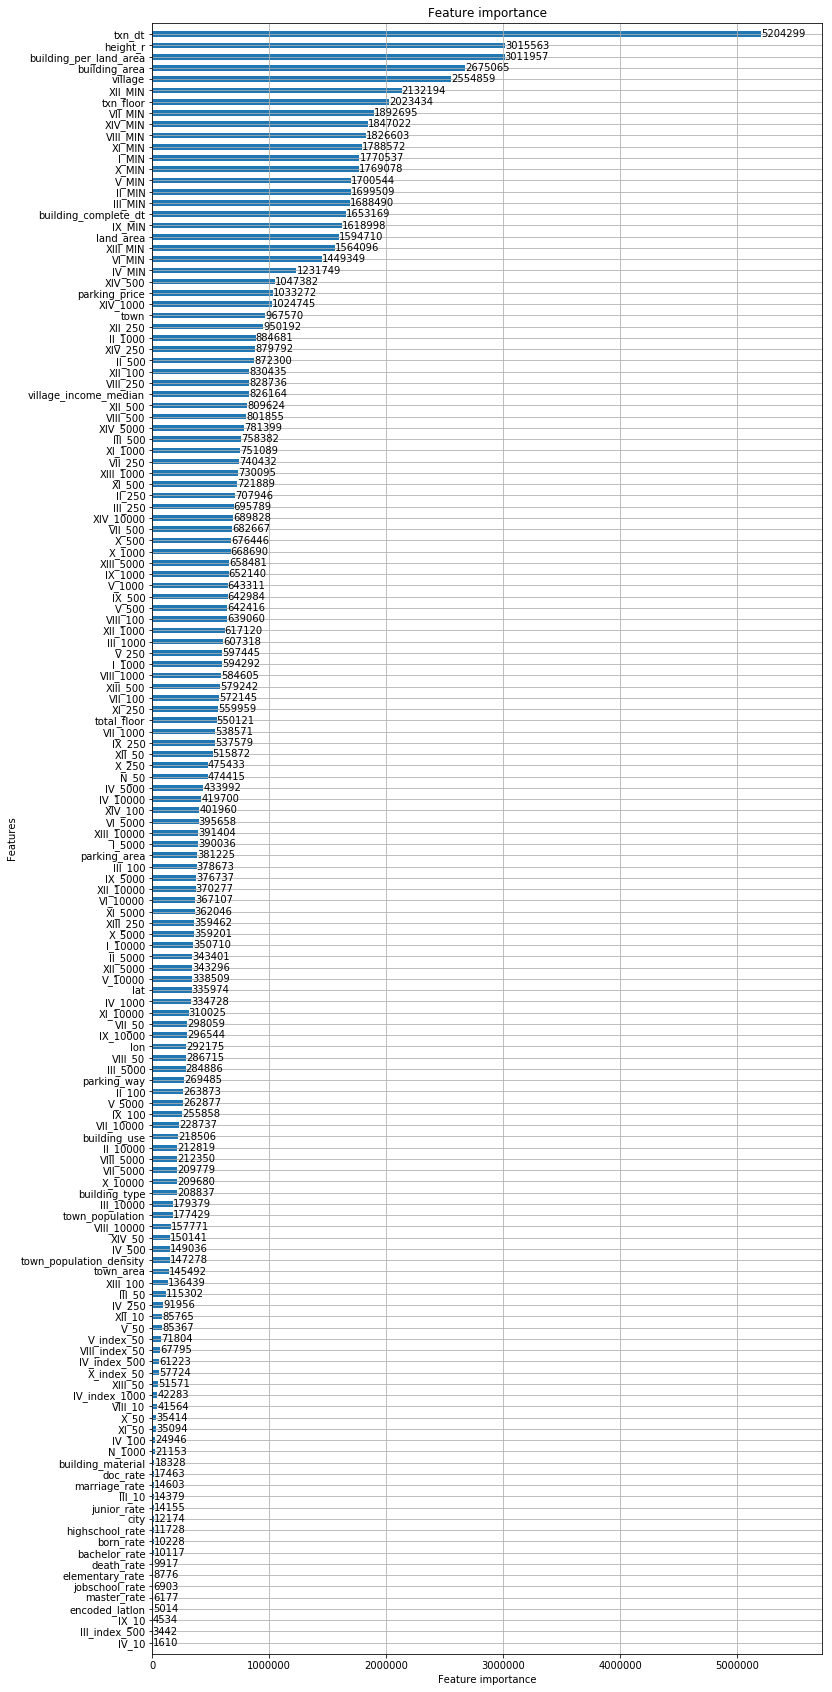

In [24]:
lgb.plot_importance(model, figsize=(12, 30), height=0.5) # 050, 051, 052
plt.show()

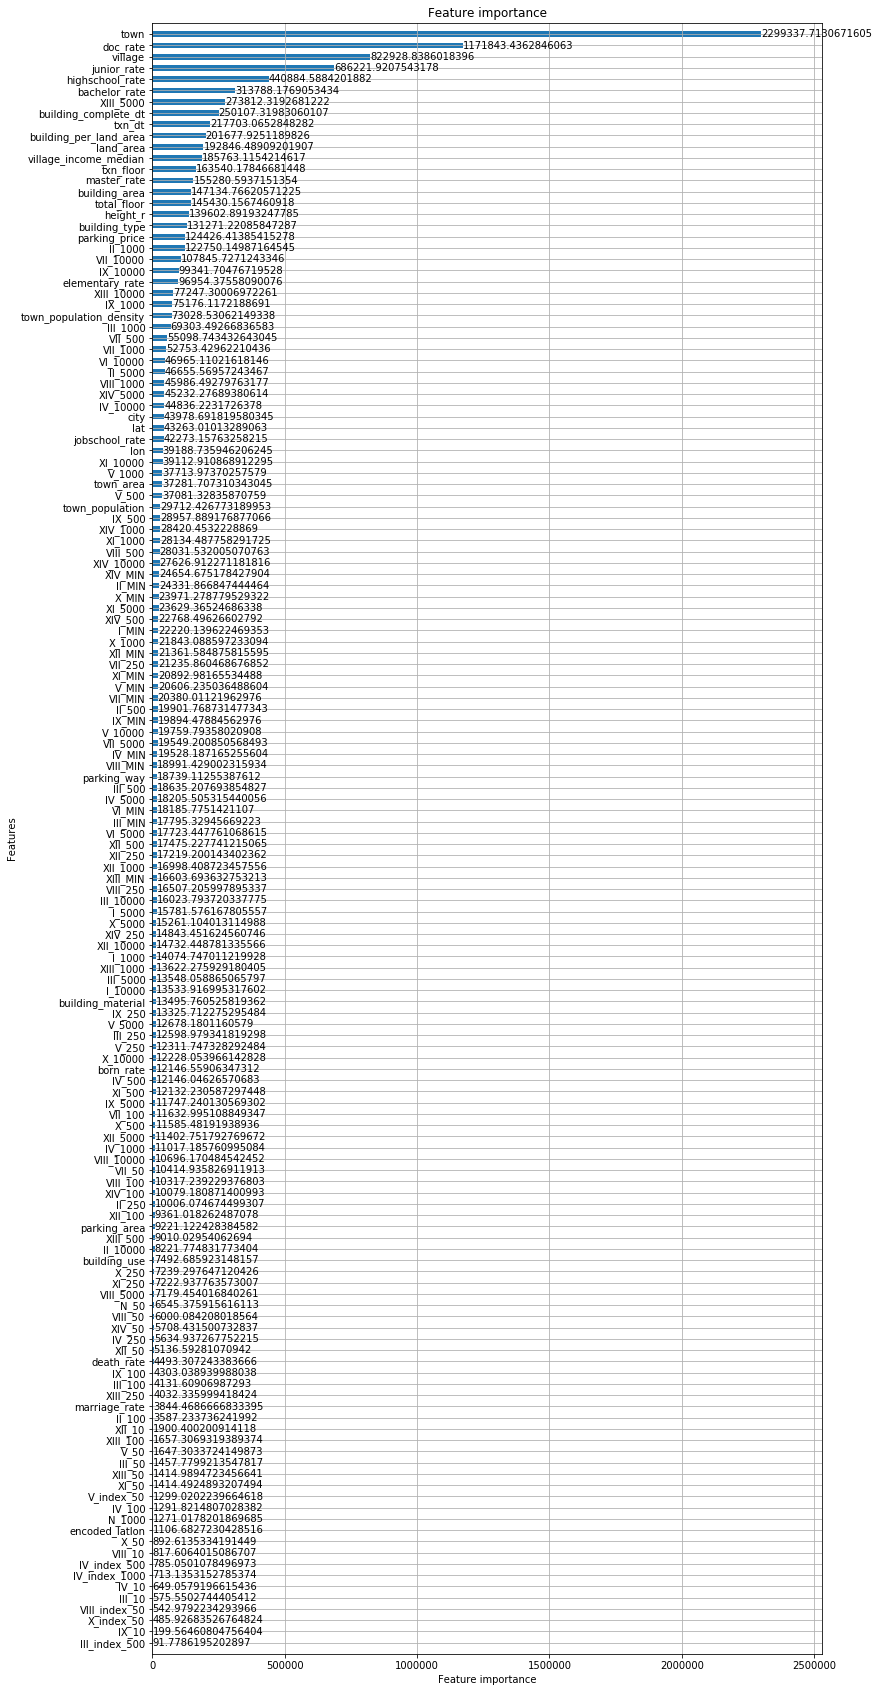

In [25]:
lgb.plot_importance(model, figsize=(12, 30), height=0.5, importance_type='gain') # 050, 051, 052
plt.show()